### Problem: 

- Running inference from the disentangled embeddings model on generated images and seemingly identical pre-computed inversions returns very different embeddings
- This notebook is to find out for how many articles this is the case

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

this_wd = os.getcwd()

In [3]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
from IPython.utils import io
import shutil
from torchvision.transforms.functional import pil_to_tensor
from torch.nn.functional import cosine_similarity

## Load Latents and Generator

In [4]:
#Load in original Latents
latents_dict = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

In [5]:
def generate_from_sku(sku):
    latent = latents_dict[sku][0].unsqueeze(0).to(device)
    img = G.synthesis(latent, force_fp32 = True, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    return img

In [6]:
try:
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
except:
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        
print(f"Using {device} as device")
# Initalize original custom SG2-Ada generator
sg2_generator_model_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/network-snapshot-001200.pkl"
os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch/")
with open(sg2_generator_model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(device)  # torch.nn.Module 
    D = architecture['D'].to(device)
os.chdir(this_wd)

Using cpu as device


### Run Tests

In [7]:
def compare(sku):
    # Generate image from sku
    gen = generate_from_sku(sku)
    # Load inversion from generated images directory
    inv = Image.open(f"{DATA_PATH}/Generated_Images/e4e/00005_snapshot_1200/{sku}.jpg").convert('RGB')

    fig, ax = plt.subplots(1,2, figsize = (13,7))
    ax[0].imshow(gen)
    ax[1].imshow(inv)
    ax[0].set_title('Generated')
    ax[1].set_title('Saved Inversion')
    ax[0].axis('off')
    ax[1].axis('off')
    cos = cosine_similarity(pil_to_tensor(gen).flatten().float(),pil_to_tensor(inv).flatten().float(), dim = 0)
    cos = np.round(cos.item(), 4)
    fig.suptitle(f'Cosine Similarity of flattened image pixels: {cos}')
    plt.show()

    # Save generation
    os.makedirs(f"{this_wd}/temp/images/", exist_ok=True)
    gen.save('temp/images/gen.jpg')
    # Copy saved inversion 
    shutil.copy(f"{DATA_PATH}/Generated_Images/e4e/00005_snapshot_1200/{sku}.jpg", f"{this_wd}/temp/images/inv.jpg")


    # Run inference from disentangling model
    os.chdir(f"{ROOT_PATH}/4_Assessor/disentangled_representations")
    from infer import infer

    model_id = 5
    infer(
            checkpoint=f'{DATA_PATH}/Models/disentangled_representations/models/{model_id}-model-best_valid_loss.pt',
            img_dir=f"{this_wd}/temp/images/",
            save_dir=f"{this_wd}/temp/inference/",
            batch_size=64,
            verbose=False,
            N=None
        )

    os.chdir(this_wd)

    # Load results
    global results
    results = pickle.load(open(f"{this_wd}/temp/inference/{model_id}.pkl", 'rb'))
    print('DinoV2_ViTB14 Similarity:')
    print(cosine_similarity(results['dinov2_vitb14'][0], results['dinov2_vitb14'][1], dim = 0))

    # TODO: Change such that it returns a dict with the similarities for each sub-embedding


    sims = {}
    for embeddings_type in results['disentangled_embeddings'].keys():
        embedings_subset = results['disentangled_embeddings'][embeddings_type]
        sims[embeddings_type] = cosine_similarity(embedings_subset[0], embedings_subset[1], dim = 0)
    print('Sub-Embeddings Similarities:')
    display(sims)

    results['disentangled_embeddings_concat'] = torch.cat([results['disentangled_embeddings'][key] for key in results['disentangled_embeddings'].keys()], dim = 1)
    print('Concatenated Embeddings Similarity:')
    print(cosine_similarity(results['disentangled_embeddings_concat'][0], results['disentangled_embeddings_concat'][1], dim = 0))

    shutil.rmtree(f"{this_wd}/temp/")

SOA21C0KG-J11


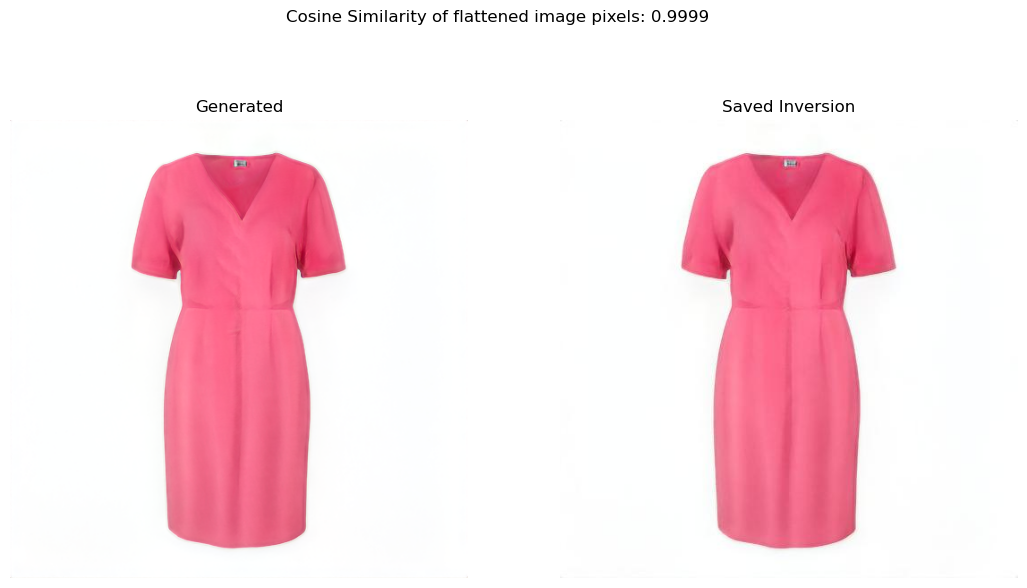

Using cache found in /home/tu/tu_tu/tu_zxmav84/.cache/torch/hub/facebookresearch_dinov2_main
Inference (batches): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

DinoV2_ViTB14 Similarity:
tensor(0.9911)
Sub-Embeddings Similarities:


{'Color': tensor(1.0000),
 'Fabric': tensor(0.9909),
 'Fit': tensor(1.0000),
 'Neckline': tensor(0.9983),
 'Pattern': tensor(0.9978),
 'Collar': tensor(0.9999),
 'Length': tensor(0.9998),
 'Shape': tensor(0.9985),
 'Sleeve_Length': tensor(0.9990)}

Concatenated Embeddings Similarity:
tensor(1.0000)


tensor([0.8124, 0.8149])

In [12]:
pti_skus = list(glob('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/*'))
pti_skus = [elem.split('/')[-1] for elem in pti_skus]

all_skus = list(latents_dict.keys())
all_skus = [elem for elem in all_skus if elem in pti_skus]
sku = np.random.choice(all_skus, 1)[0]

sku = 'SOA21C0KG-J11'
print(sku)
compare(sku)

# Load in precomputed morphs
morphs = pickle.load(open('morphs.pkl', 'rb'))
morphs.keys()

embedding_type = 'dinov2_vitb14'
cosine_similarity(results[embedding_type], morphs[embedding_type])